# HW2 - Type 1 Diabetes Detection

### In this assignment, we will do the following:
* Explore the data provided.
* Implement linear and non-linear classifiers.
* Model optimization with k-fold cross validation
* Evaluate your model performances with appropriate metrics.
* Present a 2d visualization of multi-featured data.
*Use feature selection tools.

### Theory Questions

#### Question 1

To evaluate how well our model performs at T1D classification, we need to have evaluation
metrics that measures of its performances/accuracy. Which evaluation metric is more
important to us: model accuracy or model performance? Give a simple example that
illustrates your claim.

#### Answer 1

Accuracy is the ratio of number of correct predictions to the total number of input samples.
Evaluating a model according to its performance includes a confusion matrix and determines the values of sensitivity and specificity.
In our case, we would prefer to evaluate the model based on its performance rather than accuracy. While classification accuracy 
has it's perks, it tends to create a false sense of achieving high accuracy. 
As stated in the theoretical background, the incidence of T1D is 0.33%, i.e. even a naive classifier who determine that every sample classifying as "False" would have an accuracy of 99.67% which is great, but we will misclassify sick people who need treatment. The cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests. 


#### Question 2

T1D is often associated with other comorbidities such as a heart attack. You are asked to
design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant
patient features for the algorithm may include blood pressure (BP), body-mass index (BMI),
age (A), level of physical activity (P), and income (I). You should choose between two
classifiers: the first uses only BP and BMI features and the other one uses all of the features
available to you. Explain the pros and cons of each choice.

#### Answer 2

Pro and cons of the two models:

| Model | Pro | Con |
| --- | --- | --- |
| Using BP and BMI only | Easier to visualize and interpret (2D) | Elimination of relevant features can degrade the quality of the prediction |
| | Requires less sample | |
| |  Reduces computational cost | |
| | BMI and BP are major risk factors and are highly correlated with heart attack hence those are satisfactory pararmeters to make a prediction | |
| Using all features | Features like P and A are also correlated with heart attack and therefore can contribute to making a more accurate prediction | The larger the number of features the bigger the number of samples needed in order to make a valuable prediction (exponential increase) |
| | | There might be some irrelevant features that may reduce the reliability of the prediction |
| | | It can be difficult to visualize and interpret the data because of it's multidimesionality |

We will choose the model that based on all the features and by using machine learning tools we learn we can ignore irrelevant features by using Lasso regularization for instance.

#### Question 3

A histologist wants to use machine learning to tell the difference between pancreas biopsies
that show signs of T1D and those that do not. She has already come up with dozens of
measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which
model to use. The biopsies are really similar, and it is difficult to distinguish them from the
human eye, or by just looking at the features. Which of the following is better: logistic
regression, linear SVM or nonlinear SVM? Explain your answer.

#### Answer 3

Since the biopsies cannot be separate based on looking at the features themselves, we can assume that they cannot be linearly separable. If we run a linear model on non-linearly separable data we will get poor results, so we would choose the non-linear SVM model. 

#### Question 4

What are the differences between LR and linear SVM and what is the difference in the effect/concept of their hyper-parameters tuning?

#### Answer 4

In theory LR and SVM with linear Kernel would generate very similar results, yet in reality there are some differences:

-	SVM can handle non-linear solutions using Kernel trick whereas logistic regression can only handle linear solutions.
-	SVM tries to find the widest possible separating margin, while Logistic Regression optimizes the log likelihood function, with probabilities modeled by the sigmoid function.
-	By looking on the cost function of each algorithm we can see that SVM minimizes hinge loss while logistic regression minimizes logistic loss.
-	Logistic Regression produces probabilistic values while SVM produces 1 or 0.
-	LR is more sensitive to outliers than SVM because the cost function of LR diverges faster than those of SVM. So SVM handles outliers better than LR.
-	For the kernel space, SVM is faster because its stores just support vectors.

In terms of hyper parameters, in LR we can find α (the learning rate used for gradient descent) and λ (the regularization parameter). Regularization is used to avoid over-fitting on the data. Higher the λ, higher will be regularization and the solution will be highly biased. Lower the λ, solution will be of high variance.
While in SVM the hyper parameters are C (penalty parameter) and γ (relevant only for RBF SVM. If C is small, a decision boundary with a large margin is chosen at the expense of a greater number of misclassifications. If c is large, SVM tries to minimize the number of misclassified examples which results in a decision boundary with a smaller margin. 

In conclusion, we note that the effect of raising the two hyper parameters is the opposite, if we increase the λ parameter in the LR model we get a less accurate fit to the training set, and if we raise C parameter in the SVM model we get a better fit to the training set.


#### Data Loading 

In [17]:
path = '.\HW2_data.csv'

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, log_loss, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import random

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
warnings.filterwarnings('ignore')
mpl.style.use(['ggplot']) 

random.seed(42)

Q1 - Load the data

In [19]:
dataset = pd.read_csv(path)
dataset.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0


#### Preprocessing

Replacing string parameters to be integers (0 / 1)

In [20]:
dataset = dataset.replace('No', 0).replace('Yes', 1).replace('Positive', 1).replace('Negative', 0).replace('Male', 0).replace('Female', 1)

In [21]:
dataset.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,0,1,0.0,1,0,0,0
1,42,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,1,0,0,0
2,45,0,1,1.0,0.0,1,0.0,1.0,0,0.0,0,1,0,0.0,1,0,1,0
3,59,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,1,1
4,40,1,1,1.0,1.0,1,0.0,0.0,1,1.0,0,0,1,1.0,0,0,1,0


In [22]:
keys = dataset.keys().drop('Diagnosis')

Count NaN values within the data

In [23]:
for key in keys:
    nan_count = dataset[key].isna().sum()
    if nan_count:
        print('%d NaN values found for %s' % (nan_count, key))

20 NaN values found for Increased Thirst
9 NaN values found for Sudden Weight Loss
13 NaN values found for Increased Hunger
14 NaN values found for Genital Thrush
11 NaN values found for Itching
15 NaN values found for Muscle Stiffness


In [24]:
dataset.shape

(565, 18)

We found a total number of 82 NaN values out of 9605 values (0.88% of NaN Values)

The maximum percentage of NaN values for a specific measure is 3.5%

Hence the number of NaN values is negligible

We chose to drop cases with NaN values since most of the features for this dataset are binary and estimating them could mislead the model.

In [25]:
dataset = dataset.dropna()

Seperation to features and label.

In [26]:
X = dataset[keys]
Y = dataset['Diagnosis']

In [27]:
X

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
0,45,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,0,1,0.0,1,0,0
1,42,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,1,0,0
2,45,0,1,1.0,0.0,1,0.0,1.0,0,0.0,0,1,0,0.0,1,0,0
3,59,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,1
4,40,1,1,1.0,1.0,1,0.0,0.0,1,1.0,0,0,1,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,62,0,1,0.0,0.0,1,0.0,1.0,1,1.0,1,0,1,1.0,1,1,0
519,35,0,1,0.0,0.0,0,1.0,1.0,0,0.0,1,1,0,0.0,1,0,0
562,61,1,1,0.0,0.0,0,1.0,0.0,0,0.0,1,0,0,0.0,1,0,1
563,46,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,1,0,0.0,1,0,0


In [28]:
for key in keys:
    nan_count = X[key].isna().sum()
    if nan_count:
        print('%d NaN values found for %s' % (nan_count, key))

#### Data Exploration

<AxesSubplot:ylabel='Diagnosis'>

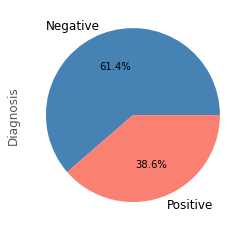

In [29]:
Y.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

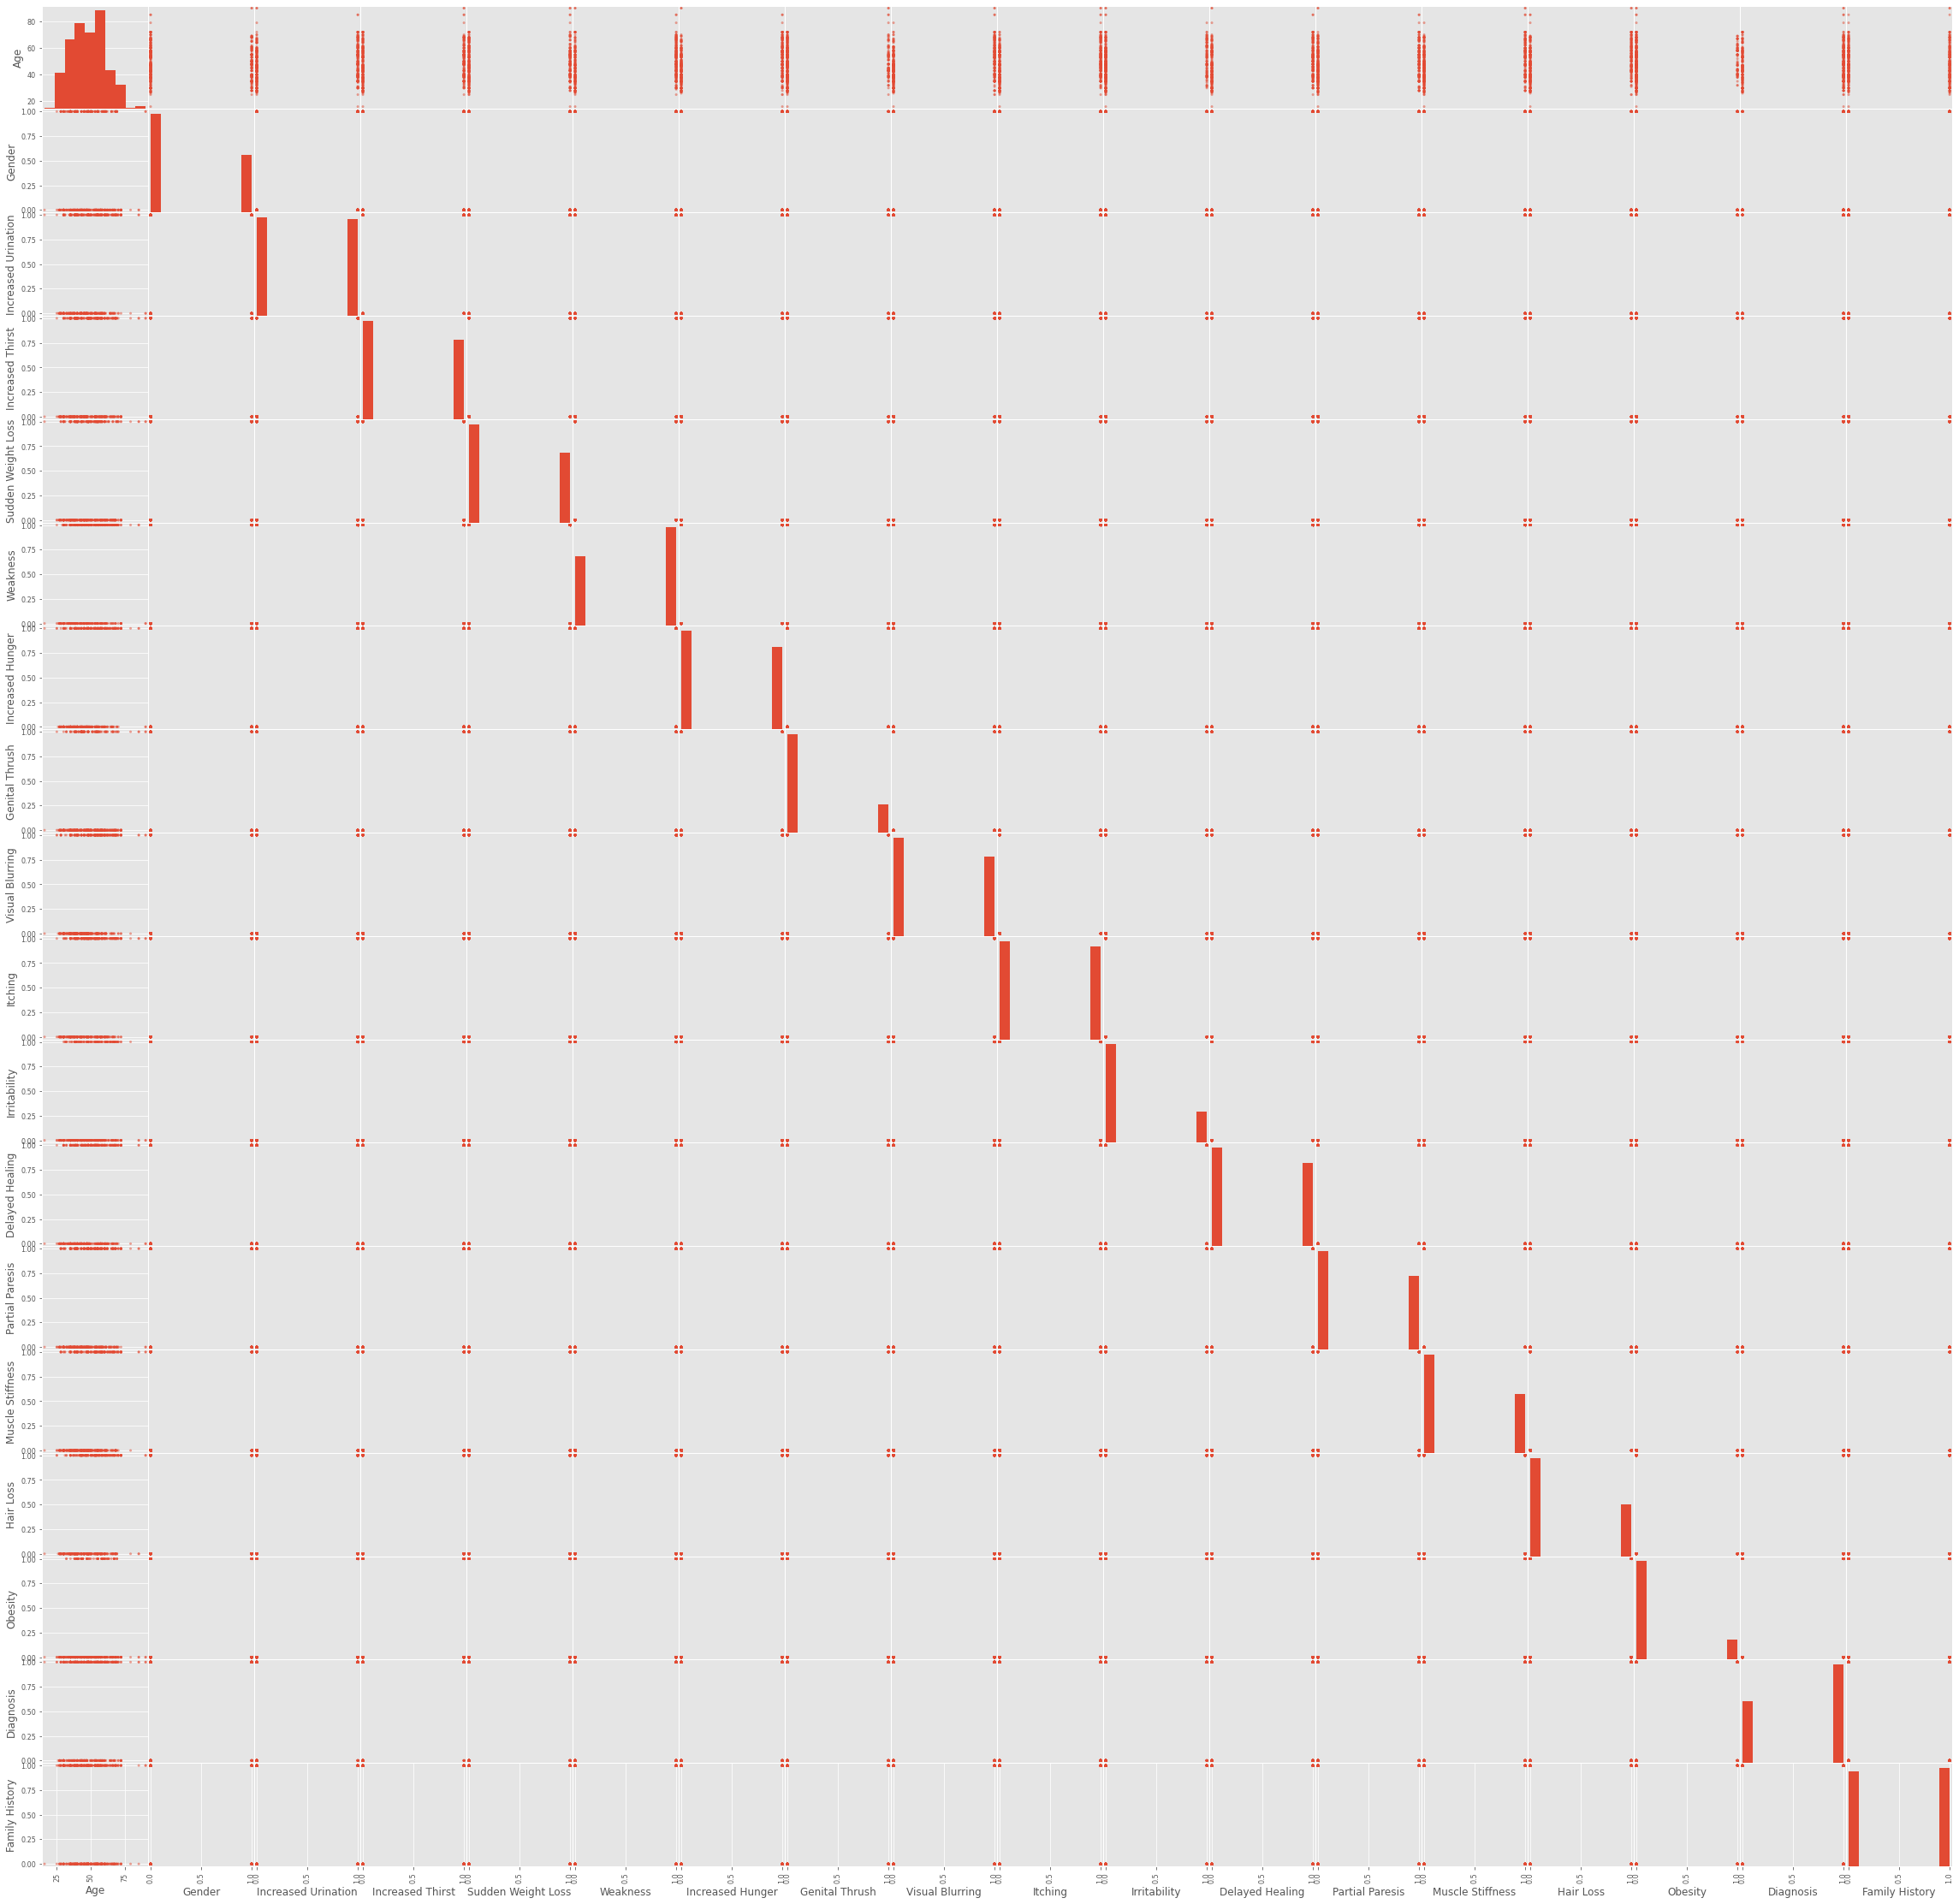

In [30]:
pd.plotting.scatter_matrix(dataset, figsize=(40, 40))
plt.show()

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Increased Urination'}>,
        <AxesSubplot:title={'center':'Increased Thirst'}>],
       [<AxesSubplot:title={'center':'Sudden Weight Loss'}>,
        <AxesSubplot:title={'center':'Weakness'}>,
        <AxesSubplot:title={'center':'Increased Hunger'}>,
        <AxesSubplot:title={'center':'Genital Thrush'}>],
       [<AxesSubplot:title={'center':'Visual Blurring'}>,
        <AxesSubplot:title={'center':'Itching'}>,
        <AxesSubplot:title={'center':'Irritability'}>,
        <AxesSubplot:title={'center':'Delayed Healing'}>],
       [<AxesSubplot:title={'center':'Partial Paresis'}>,
        <AxesSubplot:title={'center':'Muscle Stiffness'}>,
        <AxesSubplot:title={'center':'Hair Loss'}>,
        <AxesSubplot:title={'center':'Obesity'}>],
       [<AxesSubplot:title={'center':'Diagnosis'}>,
        <AxesSubplot:title={'center':'Family History'}>, <Ax

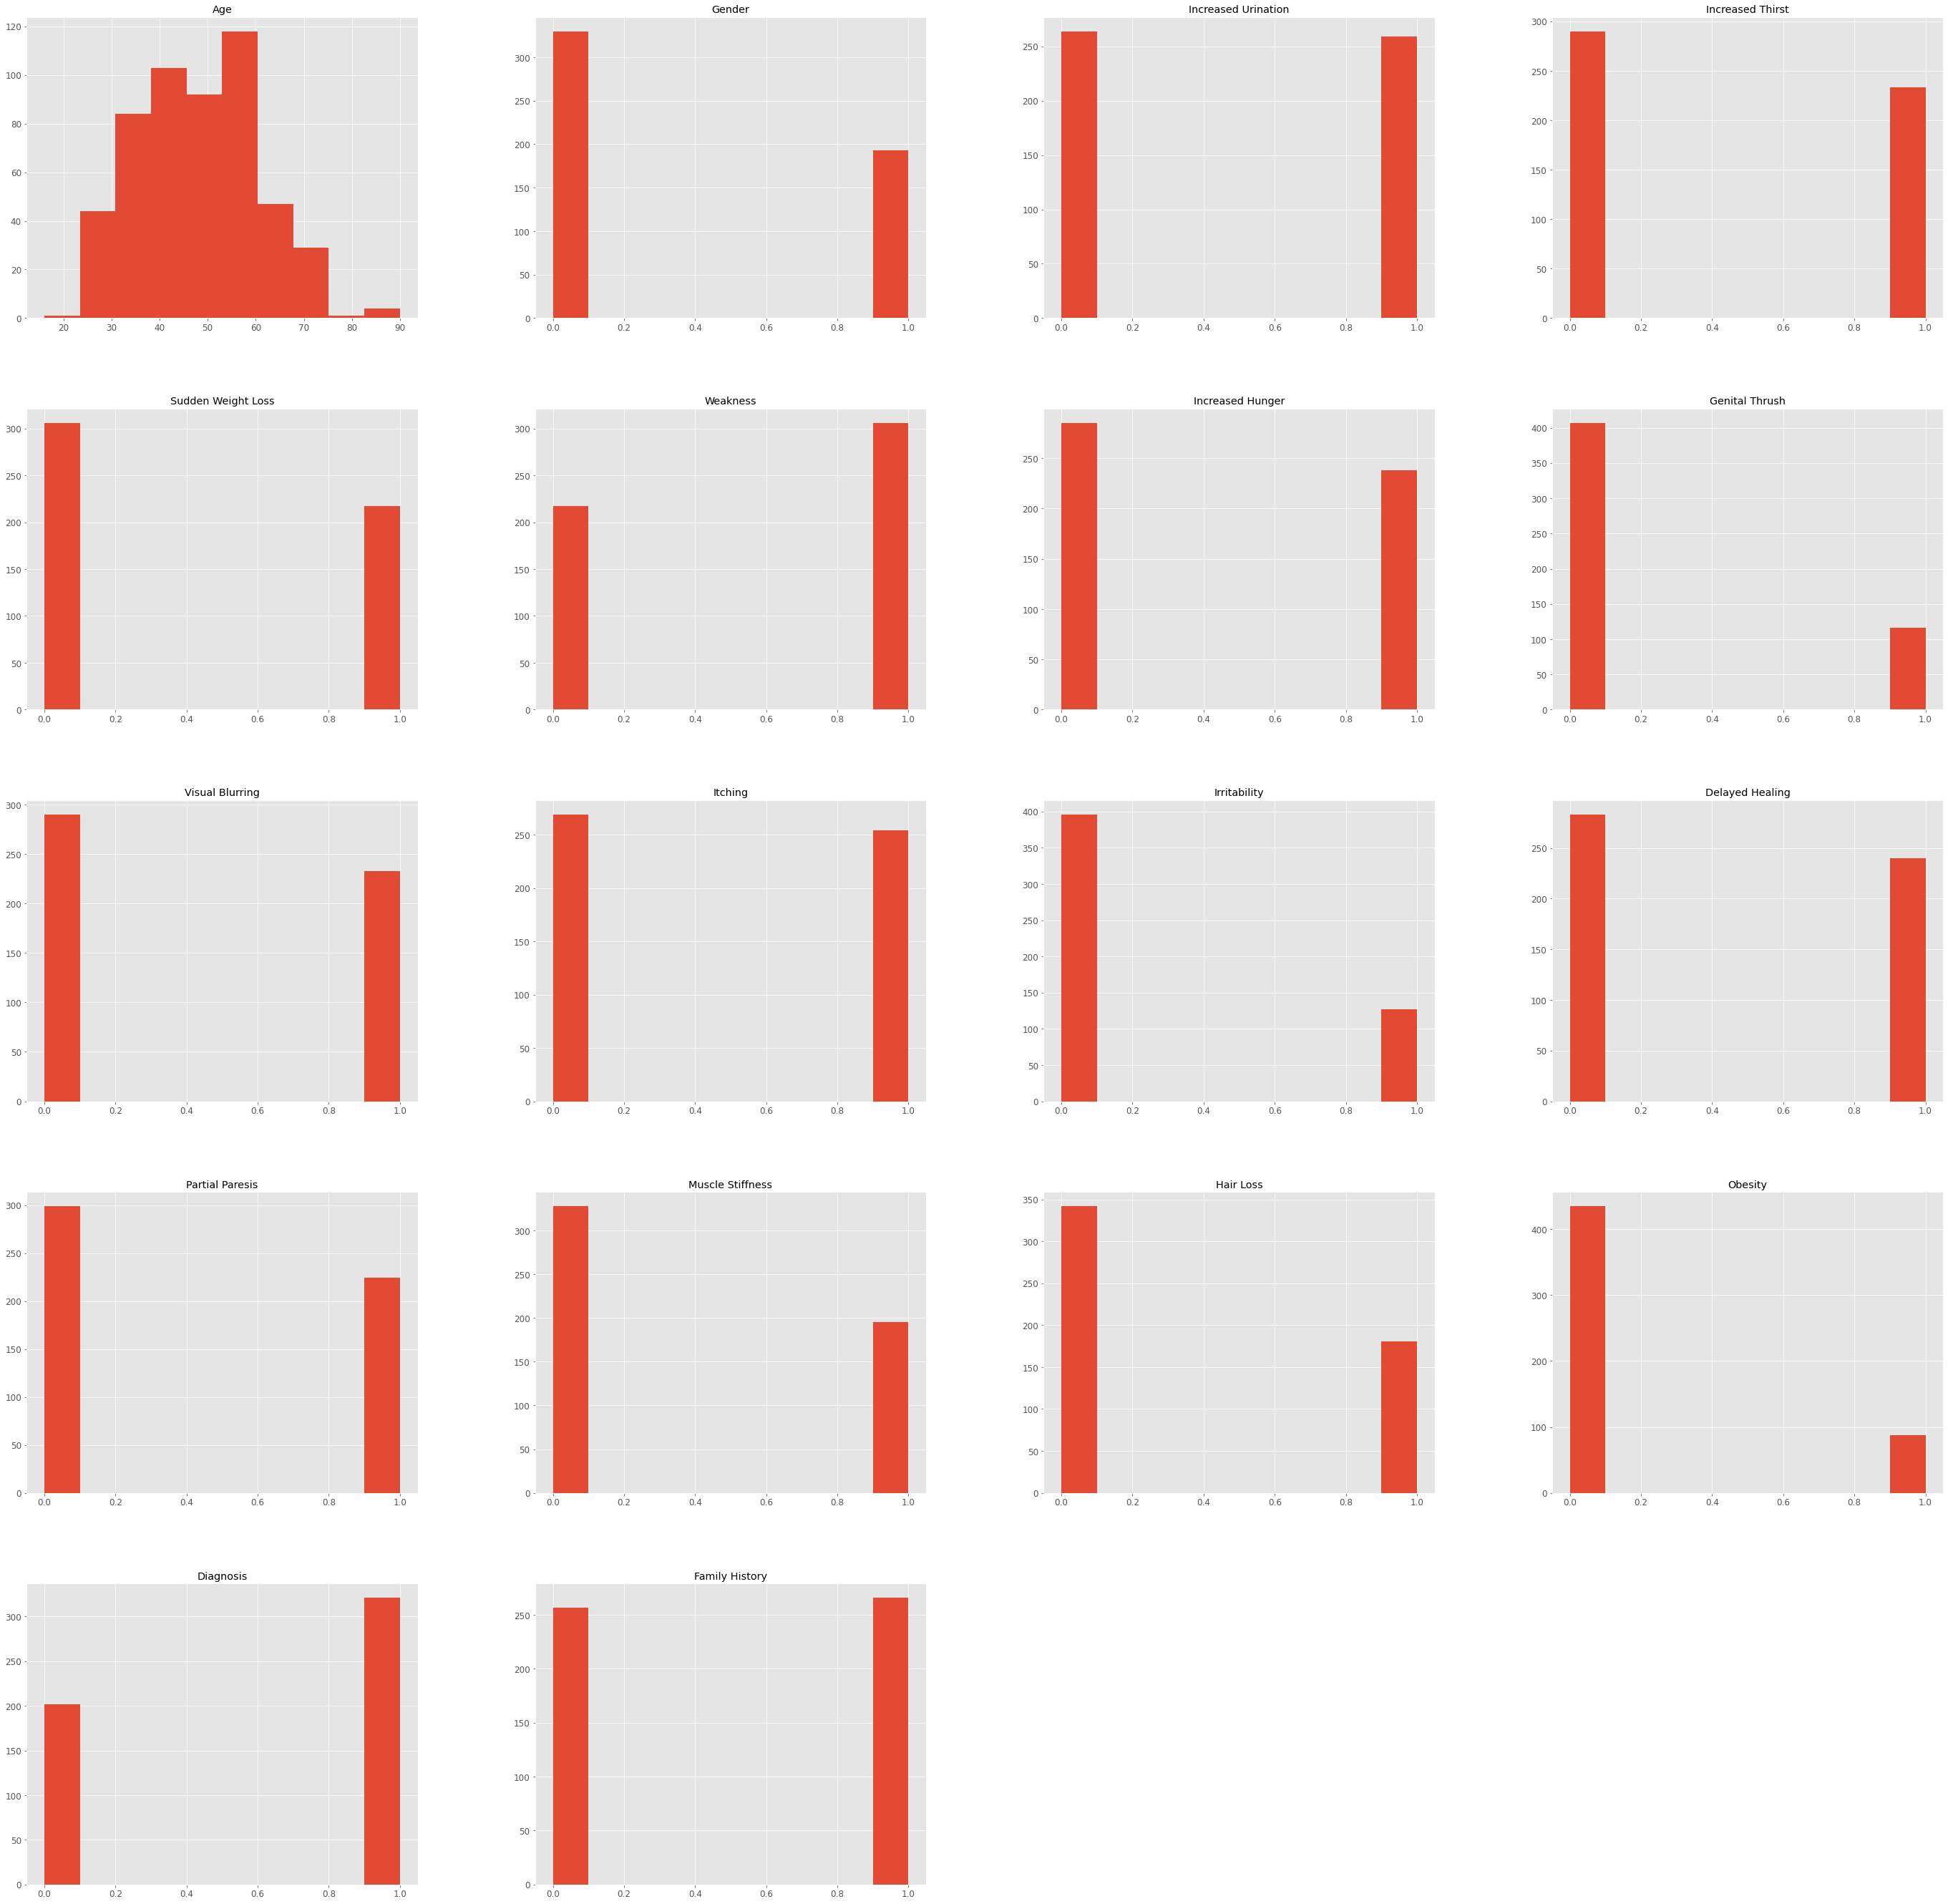

In [31]:
dataset.hist(figsize=(48, 48))

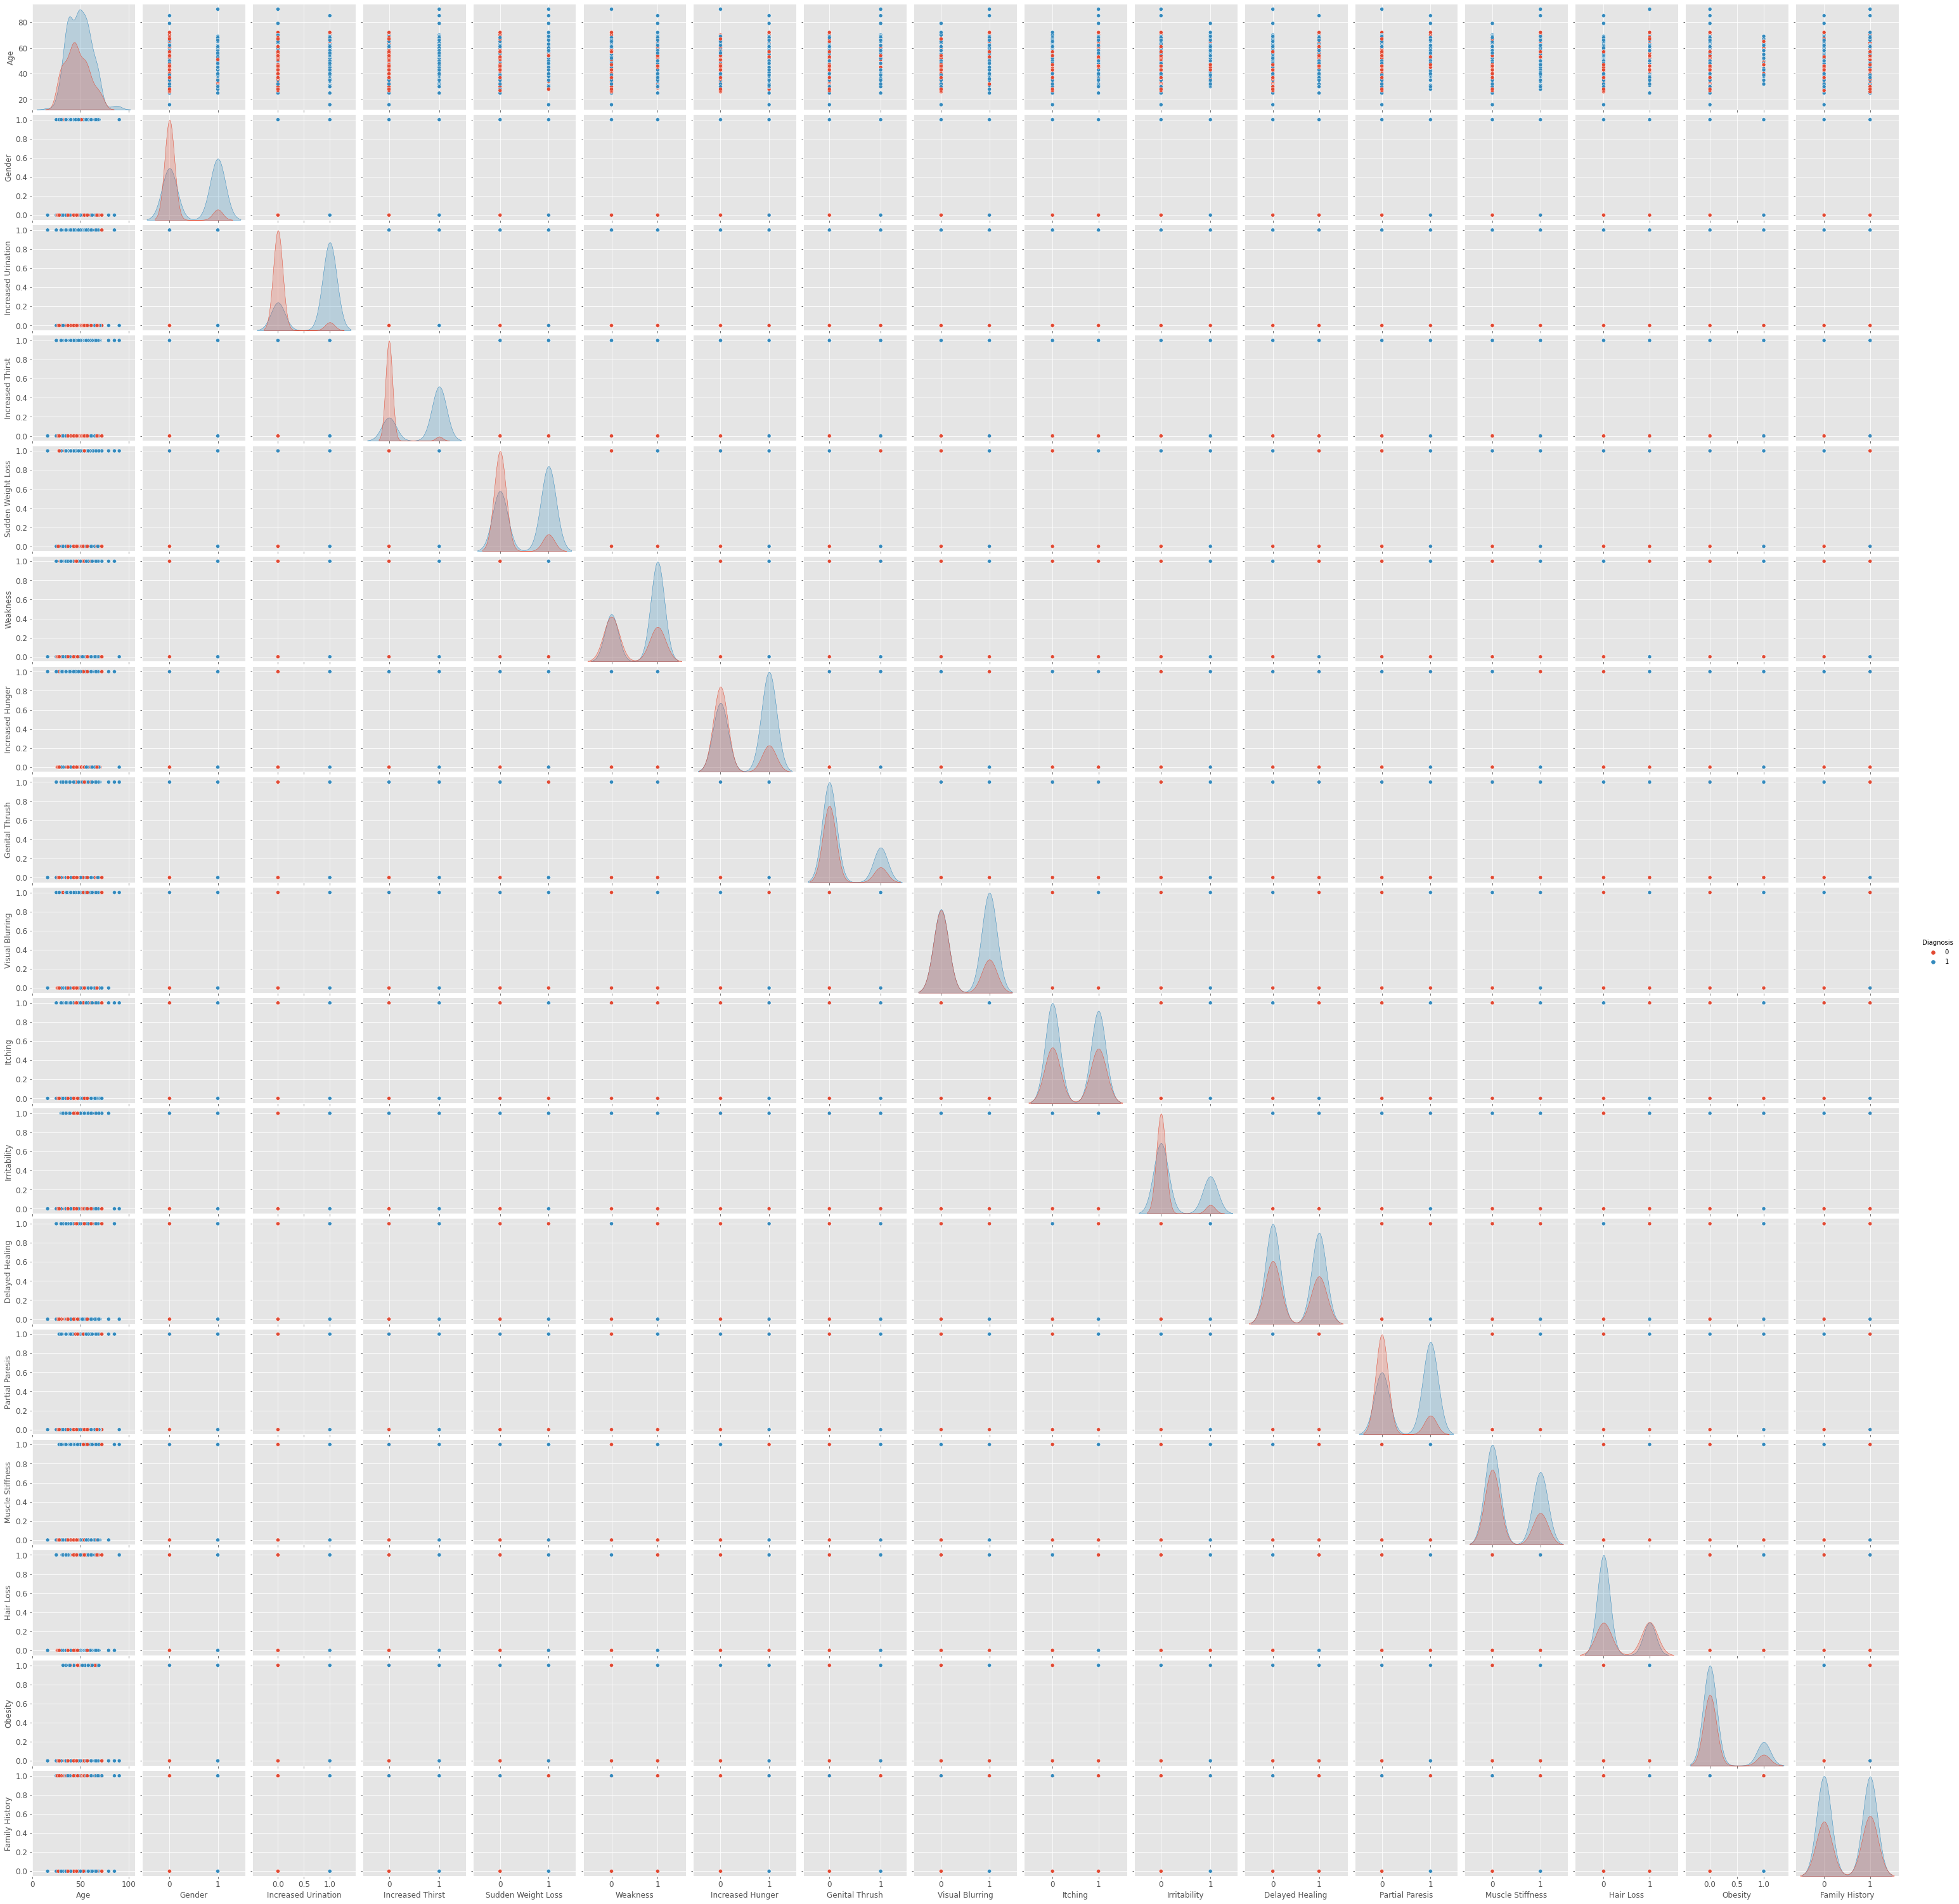

In [32]:
sns.pairplot(dataset.loc[:,:], hue="Diagnosis")

#### Data Exploration On The Divided Data

Q2 - Perform a test-train split of 20% test

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [34]:
N_train = float(X_train.shape[0])
N_test = float(X_test.shape[0])

In [35]:
percent_train = lambda feat: 100 * X_train.value_counts(feat)[1] / N_train
percent_test = lambda feat: 100 * X_test.value_counts(feat)[1] / N_test

Q3.a - An analysis to show that the distribution of the features is similar between test and train

In [36]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Positive Feature', 'Train %', 'Test %', 'Delta %']
features = [feat for feat in X_train]

for feat in features[1:]:
    c_train = percent_train(feat)
    c_test = percent_test(feat)
    table.add_row([feat, c_train, c_test, c_train - c_test])

print(table)

+---------------------+--------------------+--------------------+---------------------+
|   Positive Feature  |      Train %       |       Test %       |       Delta %       |
+---------------------+--------------------+--------------------+---------------------+
|        Gender       | 38.038277511961724 | 32.38095238095238  |  5.657325131009344  |
| Increased Urination | 50.239234449760765 | 46.666666666666664 |  3.572567783094101  |
|   Increased Thirst  |  43.7799043062201  | 47.61904761904762  |  -3.839143312827524 |
|  Sudden Weight Loss | 40.90909090909091  | 43.80952380952381  | -2.9004329004329037 |
|       Weakness      | 57.89473684210526  | 60.95238095238095  |  -3.057644110275689 |
|   Increased Hunger  | 47.36842105263158  | 38.095238095238095 |  9.273182957393487  |
|    Genital Thrush   | 22.966507177033492 | 19.047619047619047 |  3.9188881294144444 |
|   Visual Blurring   | 44.49760765550239  | 44.76190476190476  | -0.2642971064023669 |
|       Itching       | 49.04306

##### What issues could an imbalance of features between train and test cause?

Unbalanced data can result in an improper learning process of the model. Learning is based on the training set only and is therefore affected by the prevalence of the categories in it. It is possible that when we test the model on the test set, we would get incorrect classifications because of the imbalance.
In addition, for significantly unbalanced data, which for example has a very high percentage of one category, even a naive classified will give good accuracy of the model, which can be misleading.

##### How could you solve the issue?

We can solve this issue by splitting the data by the same frequency of percentages of all categories for a training set and test set. In addition, if there is a significant imbalance, we may consider evaluating the model using its performance rather than its accuracy.

In [37]:
count = lambda X, feat: (X.value_counts(feat)[0], X.value_counts(feat)[1])

Q3.b - Plots to show the relationship between feature and label

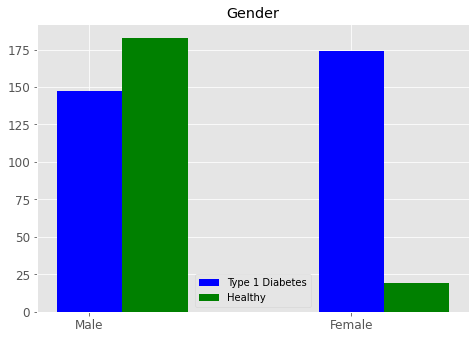

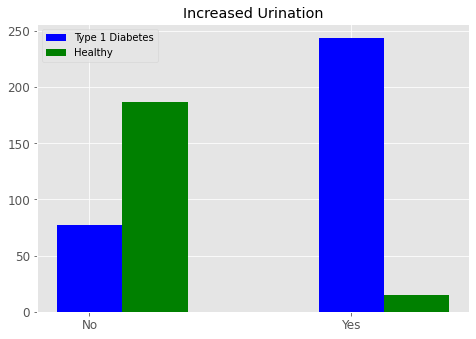

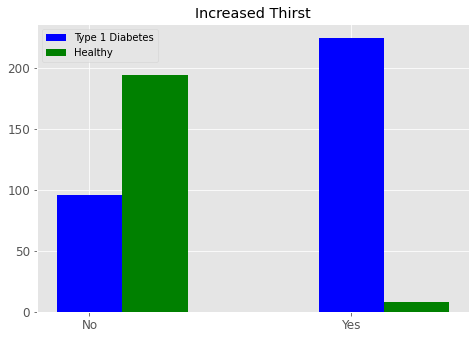

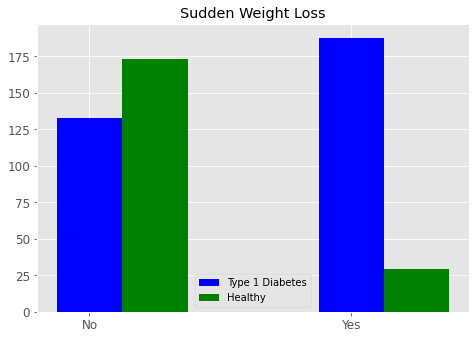

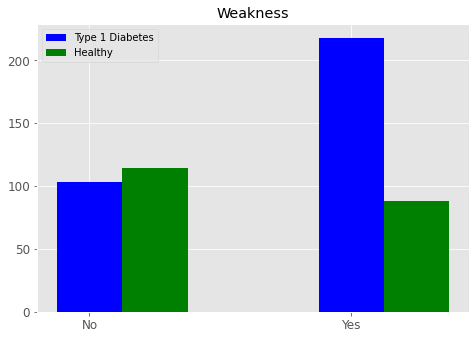

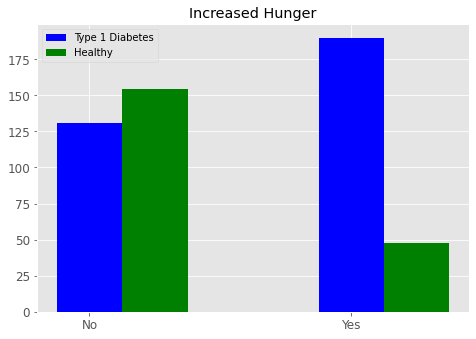

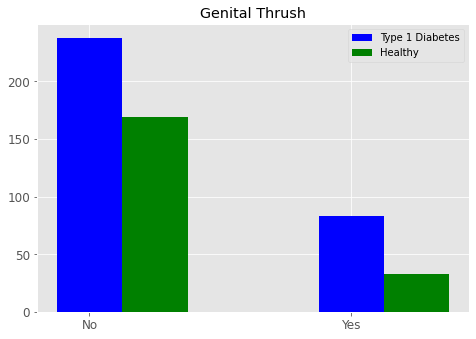

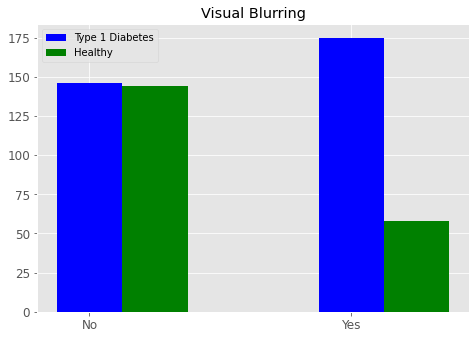

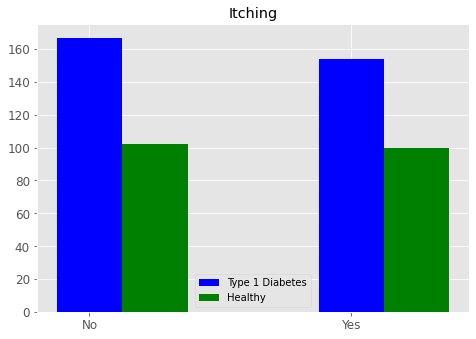

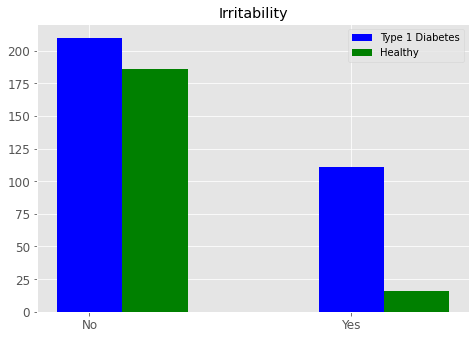

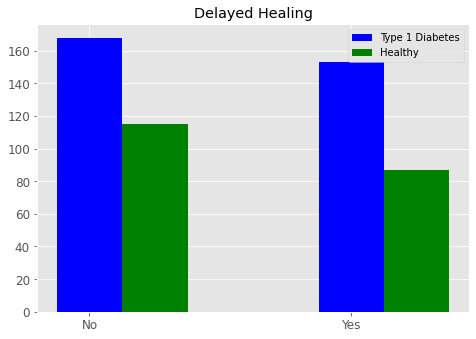

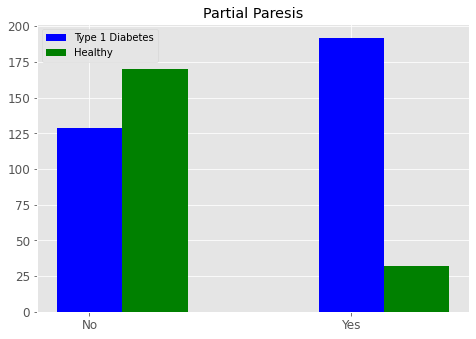

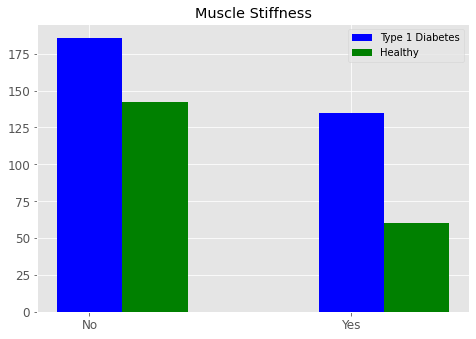

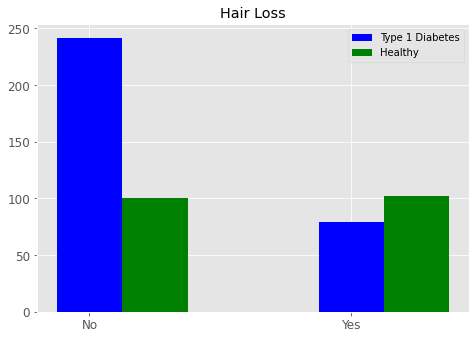

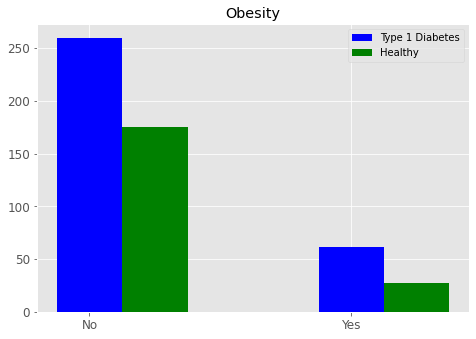

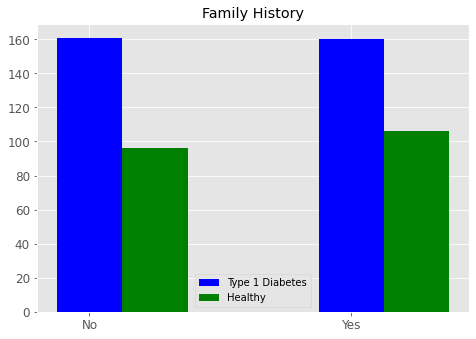

In [38]:
X_t1d = X[Y == 1]
X_norm = X[Y == 0]

for i, feat in enumerate(features[1:]):
    neg_t1d, pos_t1d = count(X_t1d, feat)
    neg_norm, pos_norm = count(X_norm, feat)
    fig = plt.figure(i)
    ax = fig.add_axes([0, 0, 1, 1])
    x = np.arange(2, step=1)
    ax.bar(x, [neg_t1d, pos_t1d], color='b', width=0.25)
    ax.bar(x + 0.25, [neg_norm, pos_norm], color='g', width=0.25)
    ax.legend(labels=['Type 1 Diabetes', 'Healthy'])
    ax.set_title(feat)
    if feat == 'Gender':
        plt.xticks(x, ('Male', 'Female'))
    else:
        plt.xticks(x, ('No', 'Yes'))
    plt.show()

Text(0.5, 1.0, 'Age Histogram Correlation To Type 1 Diabetes Diagnosis')

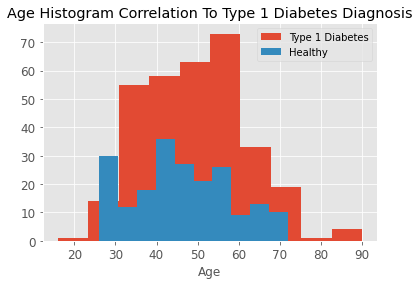

In [39]:
fig, ax = plt.subplots(1, 1)
X_t1d['Age'].hist(label='Type 1 Diabetes', ax=ax)
X_norm['Age'].hist(label='Healthy', ax=ax)
ax.legend(['Type 1 Diabetes', 'Healthy'])
ax.set_xlabel('Age')
ax.set_title('Age Histogram Correlation To Type 1 Diabetes Diagnosis')

Q3.c - Additional plot that make sense given the mostly binary nature of this dataset

Train


<AxesSubplot:ylabel='Diagnosis'>

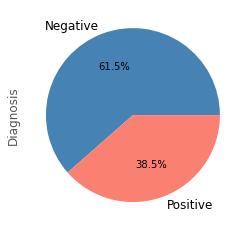

In [40]:
print('Train')
Y_train.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

Test


<AxesSubplot:ylabel='Diagnosis'>

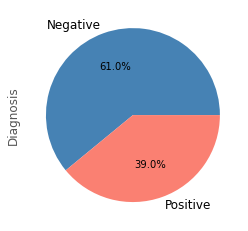

In [41]:
print('Test')
Y_test.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Increased Urination'}>,
        <AxesSubplot:title={'center':'Increased Thirst'}>],
       [<AxesSubplot:title={'center':'Sudden Weight Loss'}>,
        <AxesSubplot:title={'center':'Weakness'}>,
        <AxesSubplot:title={'center':'Increased Hunger'}>,
        <AxesSubplot:title={'center':'Genital Thrush'}>],
       [<AxesSubplot:title={'center':'Visual Blurring'}>,
        <AxesSubplot:title={'center':'Itching'}>,
        <AxesSubplot:title={'center':'Irritability'}>,
        <AxesSubplot:title={'center':'Delayed Healing'}>],
       [<AxesSubplot:title={'center':'Partial Paresis'}>,
        <AxesSubplot:title={'center':'Muscle Stiffness'}>,
        <AxesSubplot:title={'center':'Hair Loss'}>,
        <AxesSubplot:title={'center':'Obesity'}>],
       [<AxesSubplot:title={'center':'Family History'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]

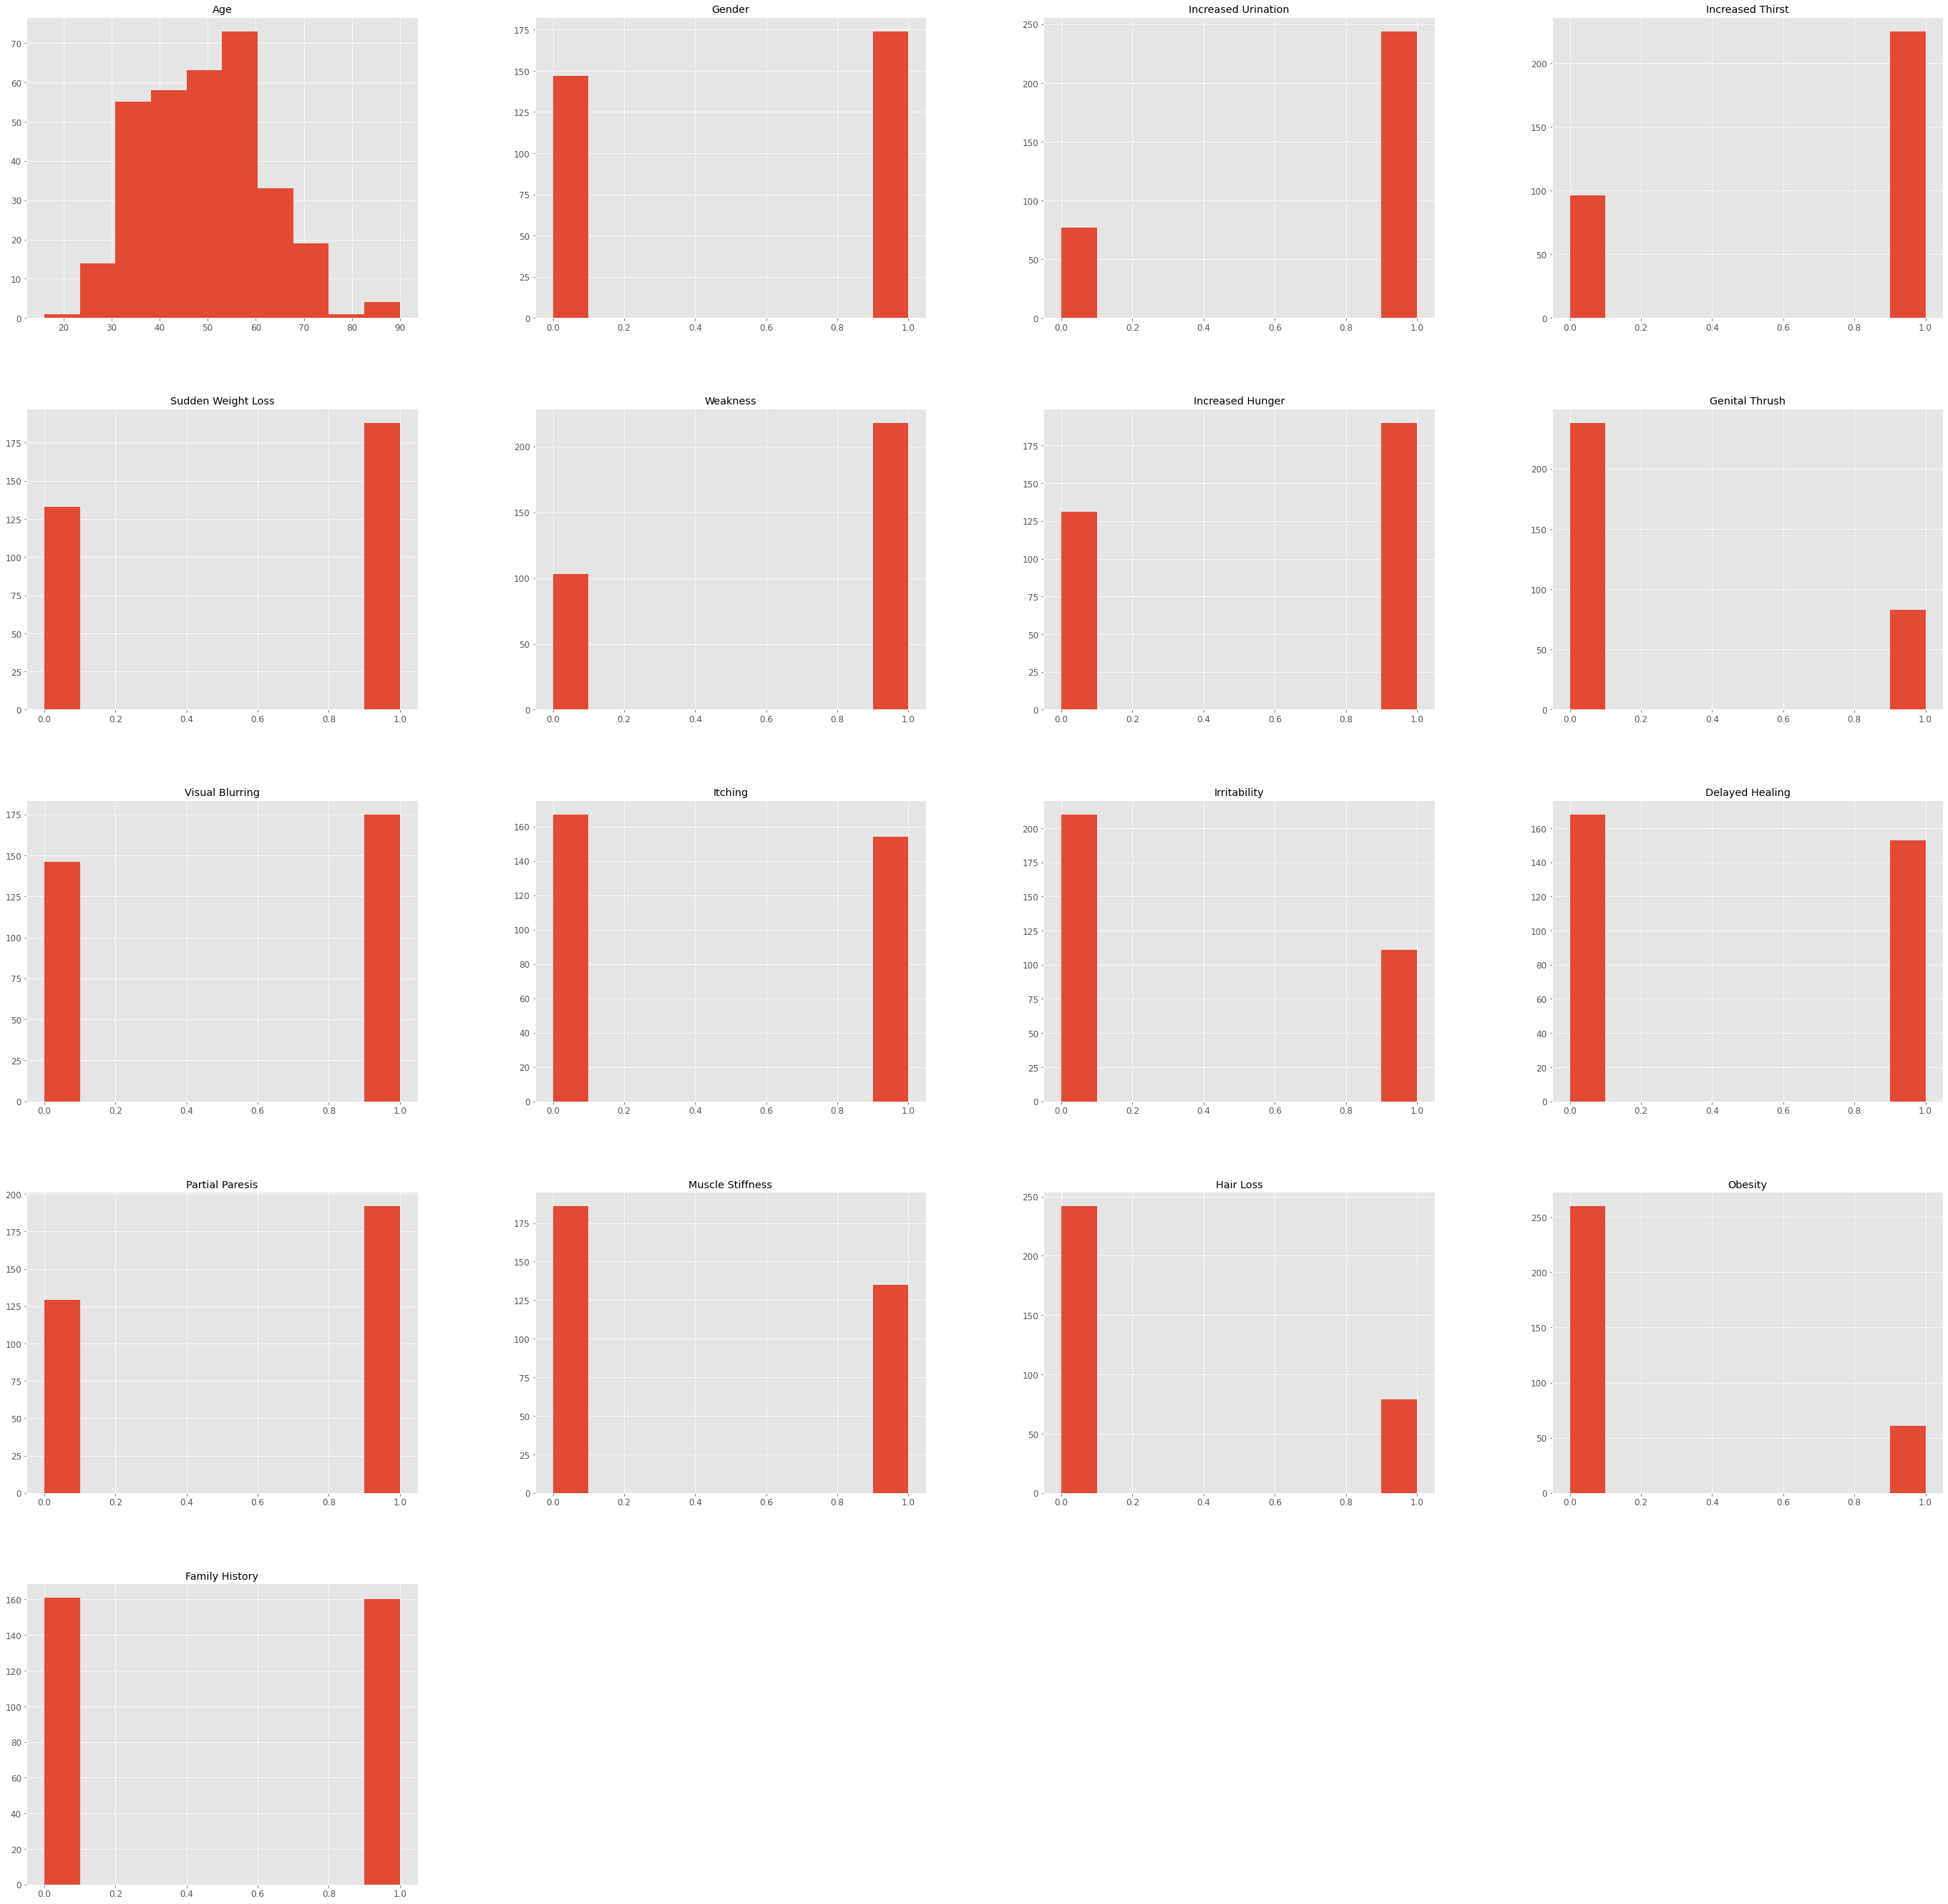

In [42]:
X_t1d.hist(figsize=(48, 48))

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Increased Urination'}>,
        <AxesSubplot:title={'center':'Increased Thirst'}>],
       [<AxesSubplot:title={'center':'Sudden Weight Loss'}>,
        <AxesSubplot:title={'center':'Weakness'}>,
        <AxesSubplot:title={'center':'Increased Hunger'}>,
        <AxesSubplot:title={'center':'Genital Thrush'}>],
       [<AxesSubplot:title={'center':'Visual Blurring'}>,
        <AxesSubplot:title={'center':'Itching'}>,
        <AxesSubplot:title={'center':'Irritability'}>,
        <AxesSubplot:title={'center':'Delayed Healing'}>],
       [<AxesSubplot:title={'center':'Partial Paresis'}>,
        <AxesSubplot:title={'center':'Muscle Stiffness'}>,
        <AxesSubplot:title={'center':'Hair Loss'}>,
        <AxesSubplot:title={'center':'Obesity'}>],
       [<AxesSubplot:title={'center':'Family History'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]

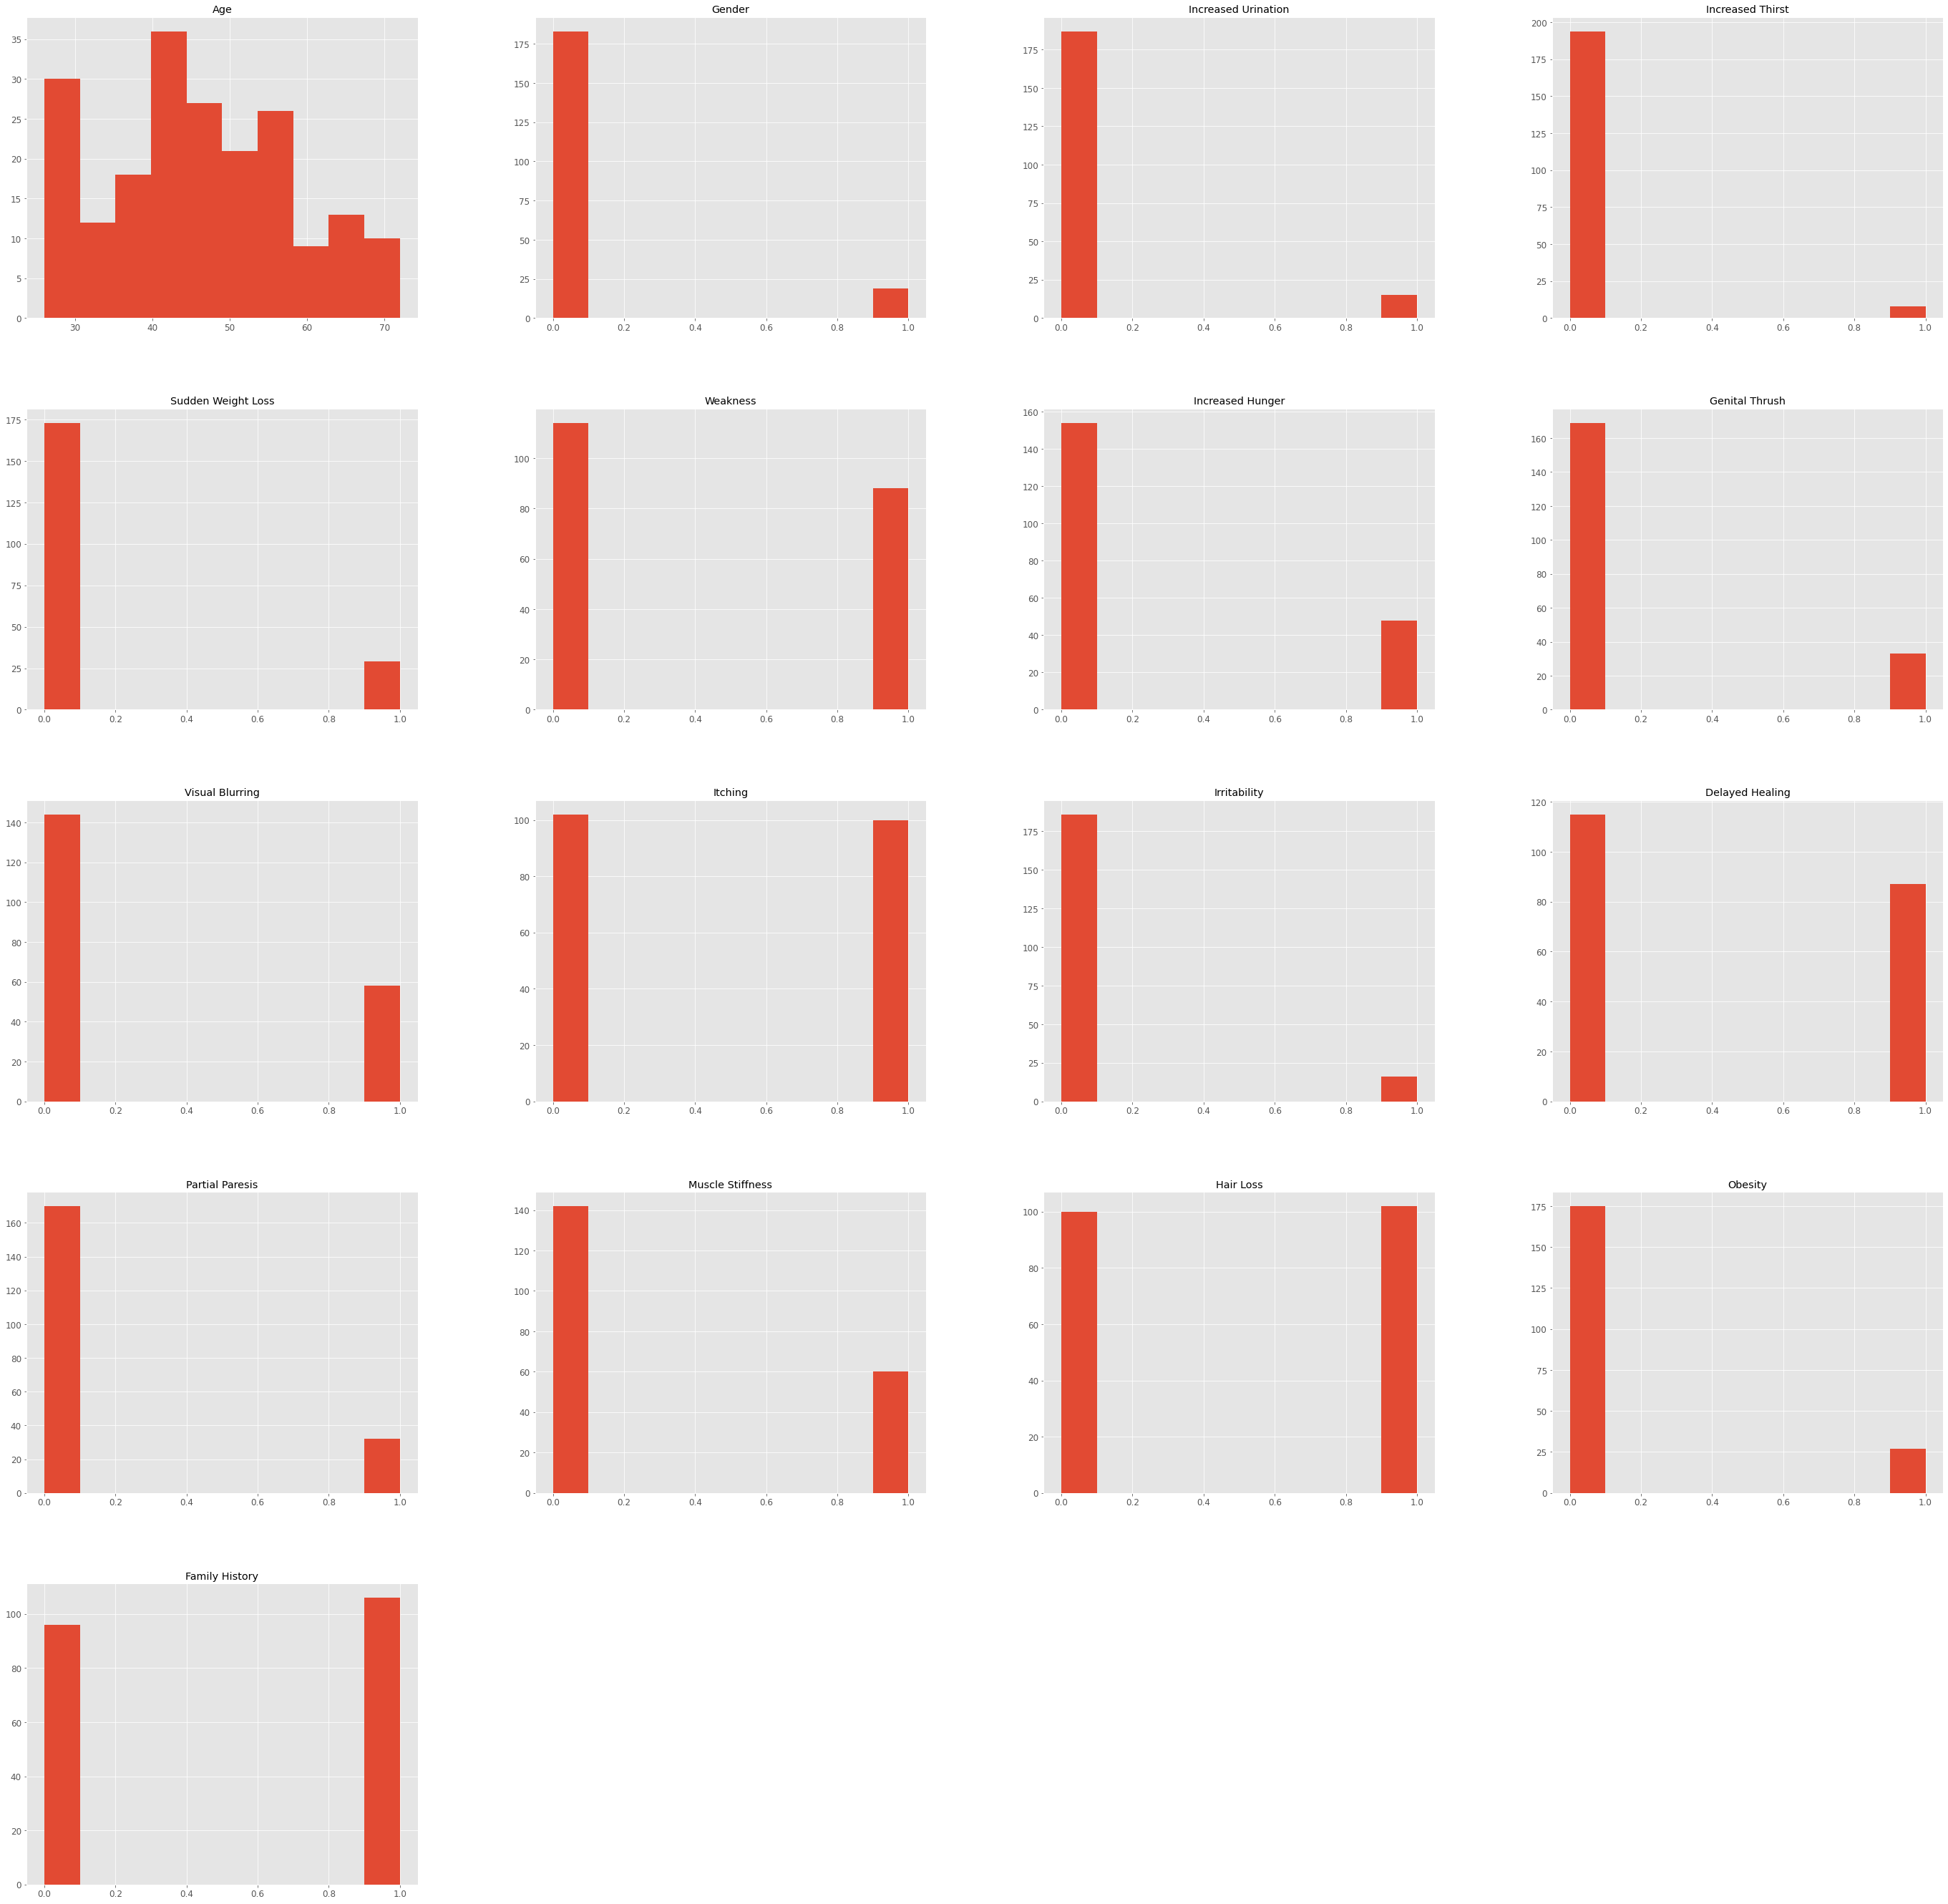

In [43]:
X_norm.hist(figsize=(48, 48))

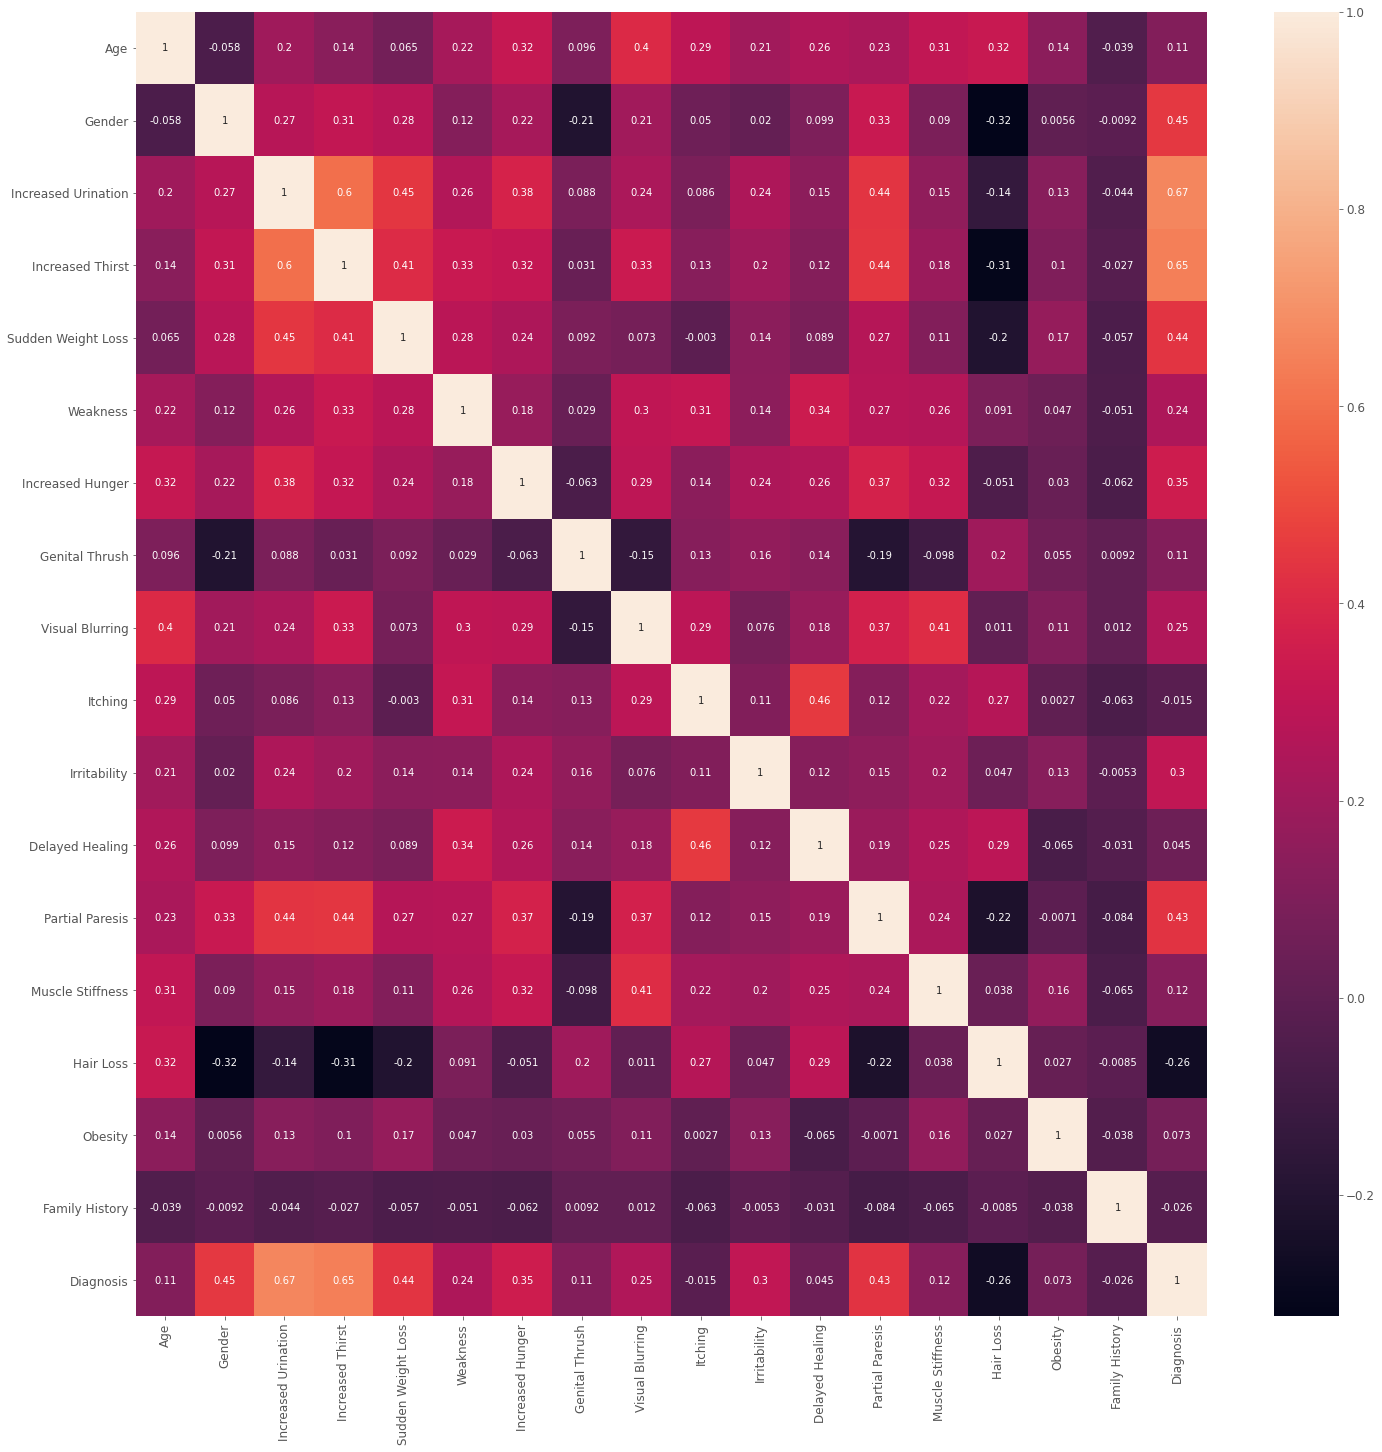

In [44]:
plt.figure(figsize = (24,24))
sns.heatmap(X.join(Y).corr(), annot = True)
plt.show()

Q3.d - State any insights gained, reference to unexpected findings and  features that can be particularly important to the model

answer:

Based on the graphs and heat map shown above, we can identify features that are highly correlated with the medical diagnosis. such features are: 'Gender', 'Increased Uritation', 'Increased Thirst' and 'Sudden Weight Loss'. this features may be very imported for the model.
We may notice unexpected values, for example most females seem to be diagnosed as positive compared to males, a result we did not expect based on our existing knowledge about the disease.
In addition, we note that for the ‘Hair Loss’ feature it is obtained that most of those who reported ‘No’ in the questionnaire are actually diagnosed as positive, even though hair loss is one of the first symptoms of the disease.



Q4 - Encoding the data as one hot vectors

In [45]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_vector = one_hot_encoder.fit_transform(dataset)
print(one_hot_vector)
print(one_hot_vector.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(523, 85)


##### Note:
From now on, the code is not organized as the questions.

The following steps are trying different models (linear and non-linear, scaled and un-scaled), using 5-cross fold validation and reporting evaluation metrics.

### Linear Classification

Naive Classifier

In [46]:
print('The naive classifier achieved an accuracy of %.2f%%.' % (100 * Y_test.value_counts()[1]/len(Y_test)))

The naive classifier achieved an accuracy of 60.95%.


Functions for evaluation

In [47]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def evaluation_metrics(Y_test, Y_pred_test):
    TN = calc_TN(Y_test, y_pred_test)
    FP = calc_FP(Y_test, y_pred_test)
    FN = calc_FN(Y_test, y_pred_test)
    TP = calc_TP(Y_test, y_pred_test)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*Se*PPV)/(Se+PPV)
    
    return Se, Sp, PPV, NPV, Acc, F1

#### Logistic Regression

Training score is 93.30 %
Test score is 93.33 %

Train loss is 0.187917
Test loss is 2.302608
Sensitivity is 0.94 
Specificity is 0.93 
PPV is 0.95 
NPV is 0.90 
Accuracy is 0.93 
F1 is 0.94 
AUROC is 0.984


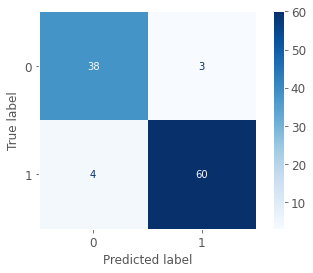

In [48]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, Y_train)
train_score = logreg.score(X_train, Y_train) * 100
test_score = logreg.score(X_test, Y_test) * 100

print("Training score is %.2f %%" % train_score)
print("Test score is %.2f %%" % test_score)

y_train_pred = logreg.predict_proba(X_train)
y_test_pred_proba = logreg.predict_proba(X_test)
y_pred_test = logreg.predict(X_test)
train_loss = log_loss(Y_train, y_train_pred)
test_loss = log_loss(Y_test, y_pred_test)
print('\r\nTrain loss is %f\nTest loss is %f' % (train_loss, test_loss))

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred_test)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_test_pred_proba[:,1])))

plot_confusion_matrix(logreg, X_test, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

K-Fold Cross Validation For Logistic Regression

In [49]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(logreg, X_train, Y_train, cv=folds, scoring=['accuracy','f1','precision', 'recall','roc_auc'])
scores

{'fit_time': array([0.11238241, 0.08029366, 0.05258608, 0.05344796, 1.39357209]),
 'score_time': array([0.01396942, 0.01737618, 0.01508474, 0.02029228, 0.03843141]),
 'test_accuracy': array([0.91666667, 0.91666667, 0.9047619 , 0.87951807, 0.96385542]),
 'test_f1': array([0.93203883, 0.94017094, 0.91836735, 0.87804878, 0.97196262]),
 'test_precision': array([1.        , 0.96491228, 0.95744681, 0.8372093 , 0.94545455]),
 'test_recall': array([0.87272727, 0.91666667, 0.88235294, 0.92307692, 1.        ]),
 'test_roc_auc': array([0.96739812, 0.98888889, 0.95187166, 0.95104895, 0.98635236])}

#### Scaled Logistic Regression 

Training score is 93.06 %
Test score is 91.43 %

Train loss is 0.182341
Test loss is 2.960489
Sensitivity is 0.91 
Specificity is 0.93 
PPV is 0.95 
NPV is 0.86 
Accuracy is 0.91 
F1 is 0.93 
AUROC is 0.984


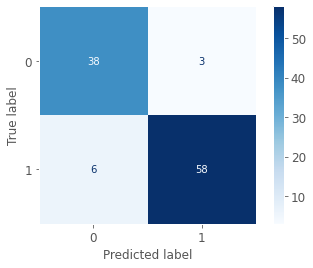

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

penalty = 'l2'
solver = 'lbfgs'

logreg_scaled = LogisticRegression(random_state=42, solver=solver, penalty=penalty, max_iter=5)
logreg_scaled.fit(X_train_scaled, Y_train)

train_score_scaled = logreg_scaled.score(X_train_scaled, Y_train) * 100
test_score_scaled = logreg_scaled.score(X_test_scaled, Y_test) * 100
print("Training score is %.2f %%" % train_score_scaled)
print("Test score is %.2f %%" % test_score_scaled)

y_train_pred = logreg_scaled.predict_proba(X_train_scaled)
y_test_pred_proba = logreg_scaled.predict_proba(X_test_scaled)
y_pred_test = logreg_scaled.predict(X_test_scaled)
train_loss = log_loss(Y_train, y_train_pred)
test_loss = log_loss(Y_test, y_pred_test)
print('\r\nTrain loss is %f\nTest loss is %f' % (train_loss, test_loss))

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred_test)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_test_pred_proba[:,1])))

plot_confusion_matrix(logreg_scaled, X_test_scaled, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

K-Fold Cross Validation For Scaled Logistic Regression

In [51]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(logreg_scaled, X_train_scaled, Y_train, cv=folds, scoring=['accuracy','f1','precision', 'recall','roc_auc'])
scores

{'fit_time': array([0.01896167, 0.00607157, 0.01049924, 0.00690222, 0.0050931 ]),
 'score_time': array([0.02932167, 0.01301193, 0.00711703, 0.00599957, 0.01109123]),
 'test_accuracy': array([0.91666667, 0.91666667, 0.91666667, 0.87951807, 0.96385542]),
 'test_f1': array([0.93333333, 0.94017094, 0.92783505, 0.87804878, 0.97196262]),
 'test_precision': array([0.98      , 0.96491228, 0.97826087, 0.8372093 , 0.94545455]),
 'test_recall': array([0.89090909, 0.91666667, 0.88235294, 0.92307692, 1.        ]),
 'test_roc_auc': array([0.96551724, 0.98472222, 0.95127748, 0.9516317 , 0.9882134 ])}

#### K-Fold Cross Validation For Linear SVM

In [52]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

In [53]:
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])

pipe = Pipeline(steps=[('scale', scaler), ('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['linear'], 'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm_lin.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.763, test=0.774) f1: (train=0.837, test=0.843) precision: (train=0.725, test=0.739) recall: (train=0.990, test=0.981) roc_auc: (train=0.957, test=0.976) total time=   0.0s
[CV 2/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.746, test=0.714) f1: (train=0.827, test=0.810) precision: (train=0.710, test=0.689) recall: (train=0.990, test=0.981) roc_auc: (train=0.953, test=0.948) total time=   0.0s
[CV 3/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.740, test=0.738) f1: (train=0.824, test=0.820) precision: (train=0.706, test=0.704) recall: (train=0.990, test=0.980) roc_auc: (train=0.954, test=0.964) total time=   0.0s
[CV 4/5] END svm__C=0.001, svm__kernel=linear; accuracy: (train=0.743, test=0.735) f1: (train=0.825, test=0.823) precision: (train=0.710, test=0.699) recall: (train=0.985, test=1.000) roc_auc: (train=0.962, test=0.956) total t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [54]:
best_svm_lin = svm_lin.best_estimator_
print(svm_lin.best_params_)

{'svm__C': 0.01, 'svm__kernel': 'linear'}


#### Linear SVM

Sensitivity is 0.84 
Specificity is 0.95 
PPV is 0.96 
NPV is 0.80 
Accuracy is 0.89 
F1 is 0.90 
AUROC is 0.981


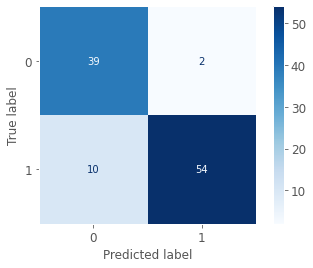

In [55]:
y_pred_test = best_svm_lin.predict(X_test_scaled)
y_pred_proba_test = best_svm_lin.predict_proba(X_test_scaled)

plot_confusion_matrix(best_svm_lin, X_test_scaled, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred_test)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba_test[:,1])))

#### K-Fold Cross Validation For Non-linear SVM

In [56]:
svm_nonlin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['rbf','poly'], 'svm__C':C, 'svm__degree':[3], 'svm__gamma':['auto','scale']},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.614, test=0.619) f1: (train=0.761, test=0.765) precision: (train=0.614, test=0.619) recall: (train=1.000, test=1.000) roc_auc: (train=0.972, test=0.981) total time=   0.0s
[CV 2/5] END svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.614, test=0.619) f1: (train=0.761, test=0.765) precision: (train=0.614, test=0.619) recall: (train=1.000, test=1.000) roc_auc: (train=0.970, test=0.957) total time=   0.0s
[CV 3/5] END svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.617, test=0.607) f1: (train=0.763, test=0.756) precision: (train=0.617, test=0.607) recall: (train=1.000, test=1.000) roc_auc: (train=0.969, test=0.982) total time=   0.0s
[CV 4/5] END svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf; accuracy: (train=0.615, test=0.614) f1: (train=0.762, test=0.

[CV 2/5] END svm__C=0.01, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; accuracy: (train=0.614, test=0.619) f1: (train=0.761, test=0.765) precision: (train=0.614, test=0.619) recall: (train=1.000, test=1.000) roc_auc: (train=0.970, test=0.957) total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; accuracy: (train=0.617, test=0.607) f1: (train=0.763, test=0.756) precision: (train=0.617, test=0.607) recall: (train=1.000, test=1.000) roc_auc: (train=0.969, test=0.982) total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; accuracy: (train=0.615, test=0.614) f1: (train=0.762, test=0.761) precision: (train=0.615, test=0.614) recall: (train=1.000, test=1.000) roc_auc: (train=0.975, test=0.957) total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=3, svm__gamma=scale, svm__kernel=rbf; accuracy: (train=0.615, test=0.614) f1: (train=0.762, test=0.761) precision: (train=0.615, test=0.614) recall: (train=1.000

[CV 1/5] END svm__C=10.0, svm__degree=3, svm__gamma=auto, svm__kernel=poly; accuracy: (train=0.994, test=0.952) f1: (train=0.995, test=0.961) precision: (train=0.990, test=0.980) recall: (train=1.000, test=0.942) roc_auc: (train=1.000, test=0.998) total time=   0.0s
[CV 2/5] END svm__C=10.0, svm__degree=3, svm__gamma=auto, svm__kernel=poly; accuracy: (train=0.994, test=0.976) f1: (train=0.995, test=0.981) precision: (train=1.000, test=0.981) recall: (train=0.990, test=0.981) roc_auc: (train=1.000, test=0.995) total time=   0.0s
[CV 3/5] END svm__C=10.0, svm__degree=3, svm__gamma=auto, svm__kernel=poly; accuracy: (train=1.000, test=0.952) f1: (train=1.000, test=0.962) precision: (train=1.000, test=0.943) recall: (train=1.000, test=0.980) roc_auc: (train=1.000, test=0.964) total time=   0.0s
[CV 4/5] END svm__C=10.0, svm__degree=3, svm__gamma=auto, svm__kernel=poly; accuracy: (train=0.994, test=0.976) f1: (train=0.995, test=0.980) precision: (train=1.000, test=1.000) recall: (train=0.990

[CV 1/5] END svm__C=100.0, svm__degree=3, svm__gamma=scale, svm__kernel=poly; accuracy: (train=0.994, test=0.952) f1: (train=0.995, test=0.961) precision: (train=0.990, test=0.980) recall: (train=1.000, test=0.942) roc_auc: (train=1.000, test=0.998) total time=   0.0s
[CV 2/5] END svm__C=100.0, svm__degree=3, svm__gamma=scale, svm__kernel=poly; accuracy: (train=0.994, test=0.976) f1: (train=0.995, test=0.981) precision: (train=1.000, test=0.981) recall: (train=0.990, test=0.981) roc_auc: (train=1.000, test=0.997) total time=   0.0s
[CV 3/5] END svm__C=100.0, svm__degree=3, svm__gamma=scale, svm__kernel=poly; accuracy: (train=1.000, test=0.952) f1: (train=1.000, test=0.962) precision: (train=1.000, test=0.943) recall: (train=1.000, test=0.980) roc_auc: (train=1.000, test=0.964) total time=   0.0s
[CV 4/5] END svm__C=100.0, svm__degree=3, svm__gamma=scale, svm__kernel=poly; accuracy: (train=0.994, test=0.940) f1: (train=0.995, test=0.949) precision: (train=1.000, test=0.979) recall: (tra

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [57]:
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 10.0, 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


#### Non-Linear SVM

Sensitivity is 1.00. 
Specificity is 0.98. 
PPV is 0.98. 
NPV is 1.00. 
Accuracy is 0.99. 
F1 is 0.99. 
AUROC is 0.996


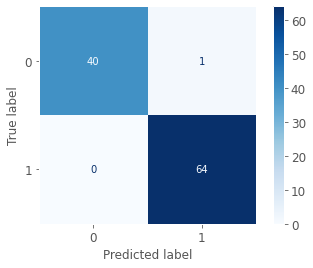

In [58]:
y_pred_test = best_svm_nonlin.predict(X_test_scaled)
y_pred_proba_test = best_svm_nonlin.predict_proba(X_test_scaled)

plot_confusion_matrix(best_svm_nonlin, X_test_scaled, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f}. \nSpecificity is {:.2f}. \nPPV is {:.2f}. \nNPV is {:.2f}. \nAccuracy is {:.2f}. \nF1 is {:.2f}. '.format(*evaluation_metrics(Y_test, y_pred_test)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba_test[:,1])))

Question 5.c.

The classifier that performed best is Non-linear SVM.

#### Random Forest Classifier

Sensitivity is 0.92. 
Specificity is 0.98. 
PPV is 0.98. 
NPV is 0.89. 
Accuracy is 0.94. 
F1 is 0.95. 
AUROC is 0.995


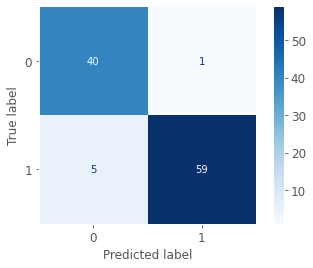

In [59]:
rfc = Pipeline(steps=[('scale', scaler), ('rfc', RandomForestClassifier(max_depth=4, random_state=42, criterion='gini'))])
rfc.fit(X_train_scaled, Y_train)

y_pred_test = rfc.predict(X_test_scaled) 
y_pred_proba_test = rfc.predict_proba(X_test_scaled)

plot_confusion_matrix(rfc, X_test_scaled, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f}. \nSpecificity is {:.2f}. \nPPV is {:.2f}. \nNPV is {:.2f}. \nAccuracy is {:.2f}. \nF1 is {:.2f}. '.format(*evaluation_metrics(Y_test, y_pred_test)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba_test[:,1])))

#### Summary Of Classifiers

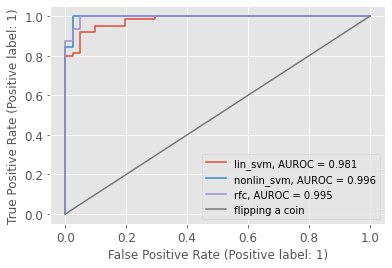

In [60]:
classifiers = [best_svm_lin, best_svm_nonlin, rfc]
roc_score = []
plt.figure()
ax = plt.gca()
for clf in classifiers:
    plot_roc_curve(clf, X_test_scaled, Y_test, ax=ax)
    roc_score.append(np.round_(roc_auc_score(Y_test, clf.predict_proba(X_test_scaled)[:,1]), decimals=3))
ax.plot(np.linspace(0,1,X_test_scaled.shape[0]),np.linspace(0,1,X_test_scaled.shape[0]))
plt.legend(('lin_svm, AUROC = '+str(roc_score[0]),'nonlin_svm, AUROC = '+str(roc_score[1]),'rfc, AUROC = '+str(roc_score[2]),'flipping a coin'))

#### Feature Selection

In [61]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_scaled, Y_train)
importance = rand_forest.feature_importances_
for i, v in enumerate(importance):
    print('Feature: % 20s, Score: %.5f' % (keys[i], v))

Feature:                  Age, Score: 0.09279
Feature:               Gender, Score: 0.09799
Feature:  Increased Urination, Score: 0.22201
Feature:     Increased Thirst, Score: 0.18924
Feature:   Sudden Weight Loss, Score: 0.04973
Feature:             Weakness, Score: 0.02197
Feature:     Increased Hunger, Score: 0.04048
Feature:       Genital Thrush, Score: 0.02473
Feature:      Visual Blurring, Score: 0.02811
Feature:              Itching, Score: 0.02726
Feature:         Irritability, Score: 0.04679
Feature:      Delayed Healing, Score: 0.02854
Feature:      Partial Paresis, Score: 0.04538
Feature:     Muscle Stiffness, Score: 0.02200
Feature:            Hair Loss, Score: 0.04148
Feature:              Obesity, Score: 0.01426
Feature:       Family History, Score: 0.00723


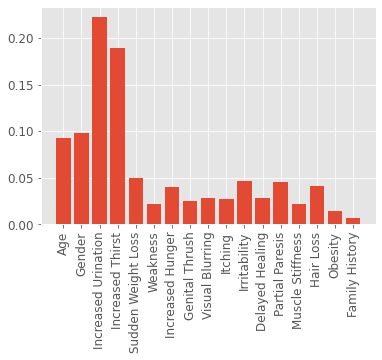

In [62]:
ax = plt.bar([keys[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

Question 6

The 2 most important features according to the random forest are increased urination and increased thirst.

This matches the feature exploration we did.

#### Data Separability Visualization